In [1]:
%autosave 0

Autosave disabled


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import Holt, ExponentialSmoothing

Reading in our store data.

In [3]:
df = pd.read_csv('stores.csv', index_col=0)
df.head()

,sale_amount,item_brand,item_name,item_price,store_address,store_zipcode,store_city,store_state,month,day_of_week,sales_total
sale_date,,,,,,,,,,,
2013-01-01,13,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,January,Tuesday,10.92
2013-01-01,26,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,12018 Perrin Beitel Rd,78217,San Antonio,TX,January,Tuesday,218.40
2013-01-01,27,Mama Marys,Pizza Sauce,4.65,12018 Perrin Beitel Rd,78217,San Antonio,TX,January,Tuesday,125.55
2013-01-01,54,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,15000 San Pedro Ave,78232,San Antonio,TX,January,Tuesday,453.60
2013-01-01,35,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,735 SW Military Dr,78221,San Antonio,TX,January,Tuesday,294.00


It gets read in a string. i have to make sure to recast it as a datetime object

In [4]:
df.index = pd.to_datetime(df.index)

We have to split our data so that we can model. I'm going with human based

In [5]:
train = df.loc[:'2015']
validate = df.loc['2016']
test = df.loc['2017']

train.shape, validate.shape, test.shape

((547500, 11), (183000, 11), (182500, 11))

We need to perform an aggregation to have one point of data per day. We can resample by the day and take the sum of the sales_total columnn.

In [6]:
day_train = train.resample('d').sales_total.sum()
day_val = validate.resample('d').sales_total.sum()
day_test = test.resample('d').sales_total.sum()

day_train.head()

sale_date
2013-01-01    73844.01
2013-01-02    73570.58
2013-01-03    78169.48
2013-01-04    84467.73
2013-01-05    87621.85
Freq: D, Name: sales_total, dtype: float64

We can visualize train/test split

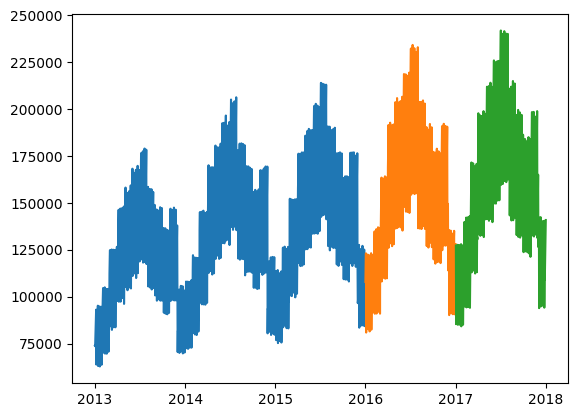

In [7]:
plt.plot(day_train)
plt.plot(day_val)
plt.plot(day_test)
plt.show()

Now that our data is properly split, let's try three different modeling approaches:
- One baseline model (rolling average)
- One non-baseline model (Holt's seasonal trend)

In [21]:
rolling = round(day_train.rolling(30).mean()[-1], 2)
rolling

105739.12

In [28]:
preds = pd.DataFrame({'actual': day_val,
                      'month_rolling': rolling})

preds.head()

,actual,month_rolling
sale_date,,
2016-01-01,107875.26,105739.12
2016-01-02,114330.43,105739.12
2016-01-03,123144.91,105739.12
2016-01-04,80873.97,105739.12
2016-01-05,95429.90,105739.12


In [29]:
hy_rolling = round(day_train.rolling(180).mean()[-1],2)


We can also create a rolling average of the last 1180 days in our dataset. This may perform better (or worse) than our monthly rolling avergae bseline.

In [30]:
preds['hy_rolling'] = hy_rolling # now we have two baseline instead of one like this we can changre the rolling line. 
preds.head()

,actual,month_rolling,hy_rolling
sale_date,,,
2016-01-01,107875.26,105739.12,145666.45
2016-01-02,114330.43,105739.12,145666.45
2016-01-03,123144.91,105739.12,145666.45
2016-01-04,80873.97,105739.12,145666.45
2016-01-05,95429.90,105739.12,145666.45


In [31]:
def eval_preds(df, predictions, actual='actual'):
    
    return round(sqrt(mean_squared_error(df[actual], df[predictions])), 2)

In [32]:
eval_preds(preds, 'month_rolling')

57384.82

Define a simple function to evaluate our model using RMSE

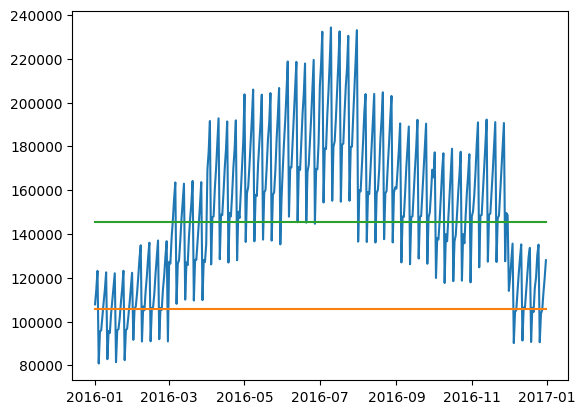

In [34]:
plt.plot(preds['actual'])
plt.plot(preds['month_rolling'])
plt.plot(preds['hy_rolling'])
plt.show()

Things i passed into my models:
- My train datset
- The number of observations before the seasonality repeatd(365)
- The type of trend in my datset('it's additive)
- seaonality is also set to additive
  
Finally, hiding at the end, I am calling the .fit() method on my model. 

In [35]:
hst_model = ExponentialSmoothing(day_train, seasonal_periods=365, trend='add', seasonal='add').fit()

/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


When I am clling .forecast() method on my model object. I specify how many observations to produce. In this case, I am asking for a number of observations equal to the days in the validate dataste.

In [14]:
hst_model.forecast(day_val.shape[0])

2016-01-01    100114.134028
2016-01-02    108505.451715
2016-01-03    112492.190484
2016-01-04    120205.367567
2016-01-05    104386.511068
                  ...      
2016-12-27    133416.358399
2016-12-28    115047.490633
2016-12-29    105504.232098
2016-12-30    110782.483640
2016-12-31    111645.544104
Freq: D, Length: 366, dtype: float64

I will add this predictions dataframe so I can evaluate them!

In [37]:
preds['hst'] = hst_model.forecast(day_val.shape[0])


After evaluating my predictions. I see that my model outperforms both baseline. 

In [39]:
eval_preds(preds, 'hst')

25942.97

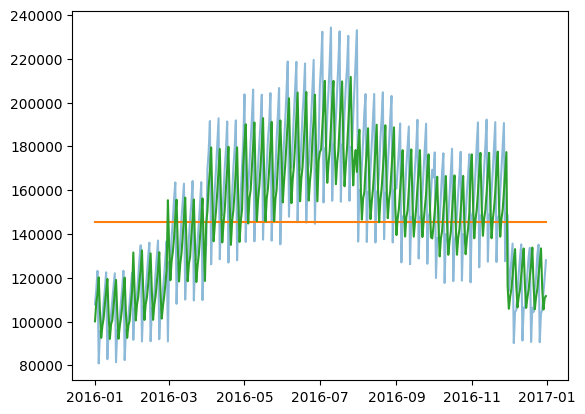

In [42]:
plt.plot(preds['actual'], alpha = 0.5)
#plt.plot(preds['month_rolling'])
plt.plot(preds['hy_rolling'])
plt.plot(preds['hst'])
plt.show()